# Exploring nonparametric methods - Regression Trees

So far in these Tutorials, we have focused on parametric methods - methods that assume a specific function family, from which the optimal function is selected to fit the data. This works well if we are quite sure that the data can be assumed to be well described by this family of functions. Non-parametric methods do not prescribe a specific form to the fitted model. Instead, the model can take any shape or form. This makes the model highly flexible, but also quite data-hungry. Non-parametric methods are therefore usually employed when the data is non-linear, the relationship between the variables is complex or unknown and/or it is not clear which of the variables could be the most important one.

In the first part of this exercise, we will use an artificial three-dimensional dataset describing a highly non-linear shape ("droplet" data from the lecture). We will first try to fit a parametric linear and a parametric non-linear function (Linear Regression and Polynomial Regression) to it and assess the goodness of fit. After that we will attempt to use non-parametric methods (Kernel Smoother and Regression Tree) and see the advantages of this method for this particular dataset.

In [39]:
library(raster)
library(rworldmap)
library(RColorBrewer)
library(kknn)
library(locfit)
library(tree)
require(randomForest)
library(dplyr)

source("functions.R")
source('../Exercise2/functions.R')


Attaching package: ‘dplyr’


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:raster’:

    intersect, select, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Create artificial data

We generate the nonlinear artificial data set. This data set will be used to showcase the capabilities of the individual methods.

In [2]:
## Create explanatory variables
yy.lim <- xx.lim <- c(-10,10)
xx <- seq(min(xx.lim),max(xx.lim),length.out=100)
yy <- seq(min(yy.lim),max(yy.lim),length.out=100)

## Get all combinations of xx and yy
xy.mat <- expand.grid(x=xx,y=yy)

## Function for creating artificial response variable
zz.fun <- function(x,y){
    r <- sqrt(x^2+y^2)
    ro <- 10 * sin(r)/r
    return(ro)
}

## Compute z for all combinations x and y
data <- data.frame(xy.mat,z=zz.fun(x=xy.mat$x,y=xy.mat$y))

## Exploratory Data Analysis

We look at the created data and try to understand its structure:

In [4]:
str(data)

# Size of the data set
sprintf("Size of the overall dataset: %i",(N.data <- nrow(data)))

'data.frame':	10000 obs. of  3 variables:
 $ x: num  -10 -9.8 -9.6 -9.39 -9.19 ...
 $ y: num  -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 ...
 $ z: num  0.707 0.708 0.694 0.666 0.626 ...


[1] "Size of the overall dataset: 10000"

The data consists of three variables `x`, `y`and `z`. Each of the variables has 10000 observations. Since we created it with the mathematical expressions from above, it is noise-free. We add normal distributed noise to each value of `z`(our predictand) to create a typical statistical learning problem.

In [5]:
set.seed(101)   ## makes random number generation reproducible
noise.sd <- 0.5 ## standard deviation of noise; you can change it if you want
data$z.noisy <- data$z + rnorm(nrow(data),mean=0,sd=noise.sd)

Now we split the data into a *test* and a *training* set randomly. Half of the data is in the test set, the other half in the training set. You can change the fraction of test data (now 0.5) if you want. The larger the test set is, the smaller is the training set. Since our methods are data-hungry, a small training set might make it more difficult to come up with a good fit.

In [6]:
## Let's use half of the data for training:
frac.test <- 0.5

## Get indices of test data:
test.ind <- sample(N.data,round(frac.test*N.data))

## Select test data:
test.data <- data[test.ind,]

## Select training data:
train.data <- data[-test.ind,]

## Size of training data
sprintf("Size of training dataset: %i",(N.train.data <- nrow(train.data)))

## Size of test data
sprintf("Size of testing dataset: %i",(N.test.data <- nrow(test.data)))

[1] "Size of training dataset: 5000"

[1] "Size of testing dataset: 5000"

At last, an overview of the created dataset. In the first plot, you see the true function that we have created. In the second, you see the dataset after we have added the normally distributed noise in the `z` direction. The two lower panels show the points belonging to test and training set, respectively.

This is the dataset that we will now use to fit our models.

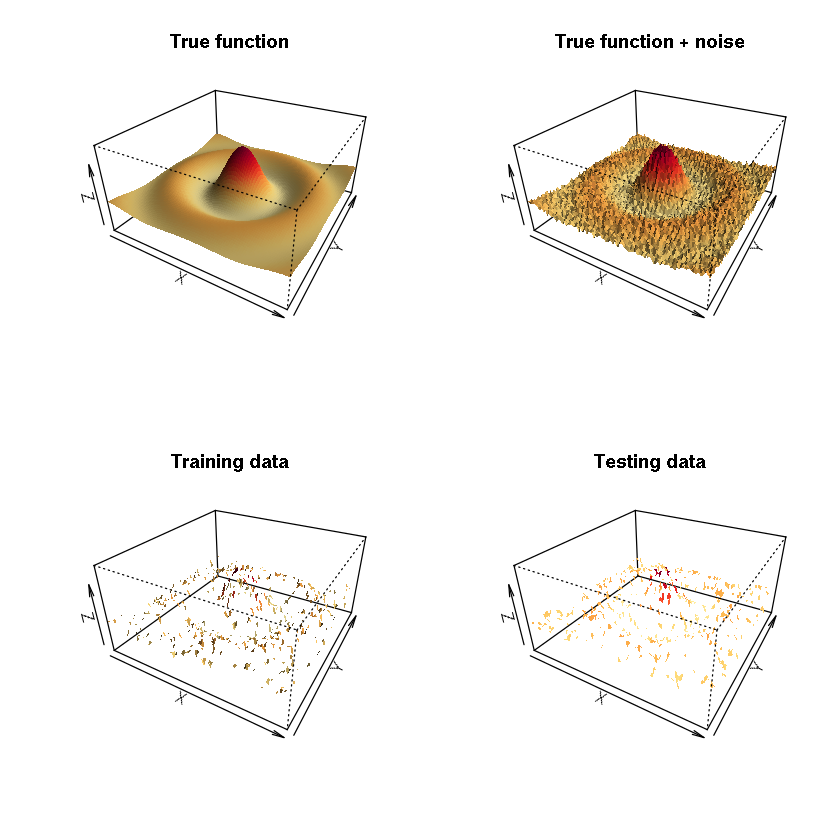

In [7]:
par(mfrow=c(2,2))
plot.xyz.persp(x=data$x,y=data$y,z=data$z,axnames=T,title="True function")
plot.xyz.persp(x=data$x,y=data$y,z=data$z.noisy,title="True function + noise")
plot.xyz.persp(x=train.data$x,y=train.data$y,z=train.data$z.noisy,title="Training data")
plot.xyz.persp(x=test.data$x,y=test.data$y,z=test.data$z.noisy,title="Testing data")

# Good ol' Linear & Polynomial Regression

First, we try some well known parametric models that you already know, a Linear Regression and a Polynomial Regression. You might already think that it is not the optimal idea to fit a Linear Regression to the training dataset. However, you might have a less clear idea if a Polynomial Regression could sufficiently model the data. Let's try both and see if we understand what is going on:

  (Intercept)             x             y 
 0.1600213856  0.0023518719 -0.0007351705 


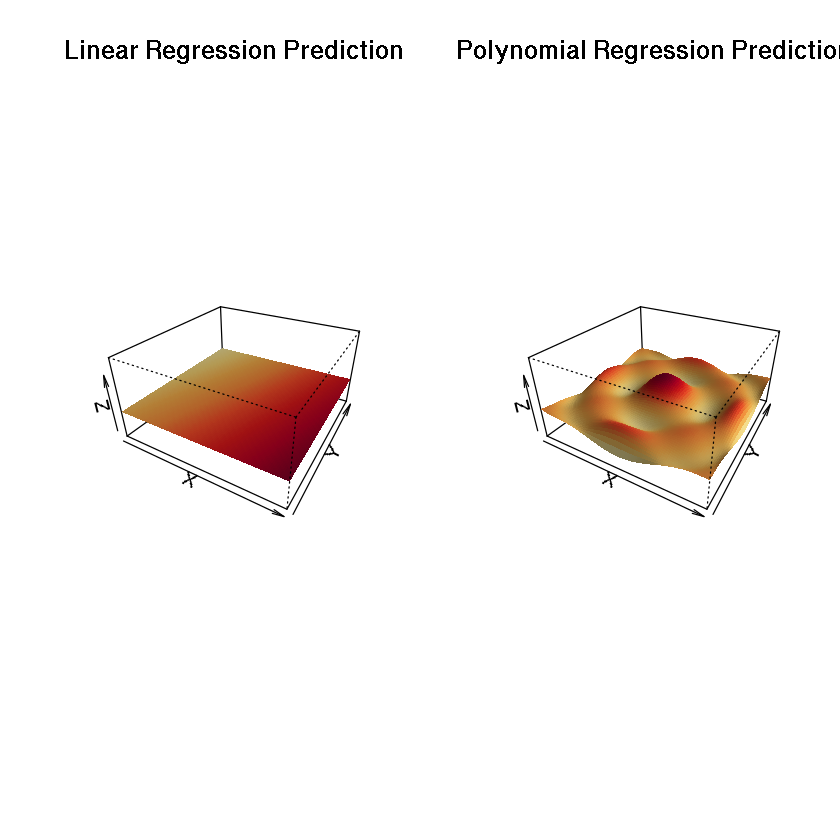

In [8]:
par(mfrow=c(1,2))

## Fit linear regression model and make prediction:
lm.fit <- lm(z.noisy~x+y,data=train.data)
print(lm.fit$coefficients)
plot.xyz.persp(x=data$x,y=data$y,z=predict(lm.fit,newdata=data),axnames=T,title="Linear Regression Prediction")

## Fit polynomial regression of order 6 (with interactions):
lm.poly.fit <- lm(z.noisy~poly(x,6) * poly(y,6),data=train.data)
plot.xyz.persp(x=data$x,y=data$y,z=predict(lm.poly.fit,newdata=data),axnames=T,title="Polynomial Regression Prediction")

<div class="alert alert-block alert-info">
<b>Questions</b> 

- What does the Linear Regression predict?
- How does the pattern in polynomial regression evolve?
- Why do we need more complex models for this type of data?
</div>

## Kernel Smoother

Cleary, other methods are necessary in this case. In the lecture you have learned about a model class we called "Kernel Smoothers". Sometimes they are also called LOESS functions ("local estimated scatterplot smoothing").

This family of methods locally approximate a simple (e.g. linear) function and puzzle together those linear approxmations to retrieve a global function. K-nearest neighbor Regression, a method that we already extensively used in the last tutorials, can also be viewed as a Kernel Smoother, where the local approximation is simply the mean of the $k$ nearest neighboring datapoints.

### Good ol' knn (now in 2D)

For simplicity and speed, we start with a subset of the training data, choosing randomly 100 data points from the 5000 training data points. We exemplarily choose 1, 10 and 100 as $k$ values and plot the prediction surface:

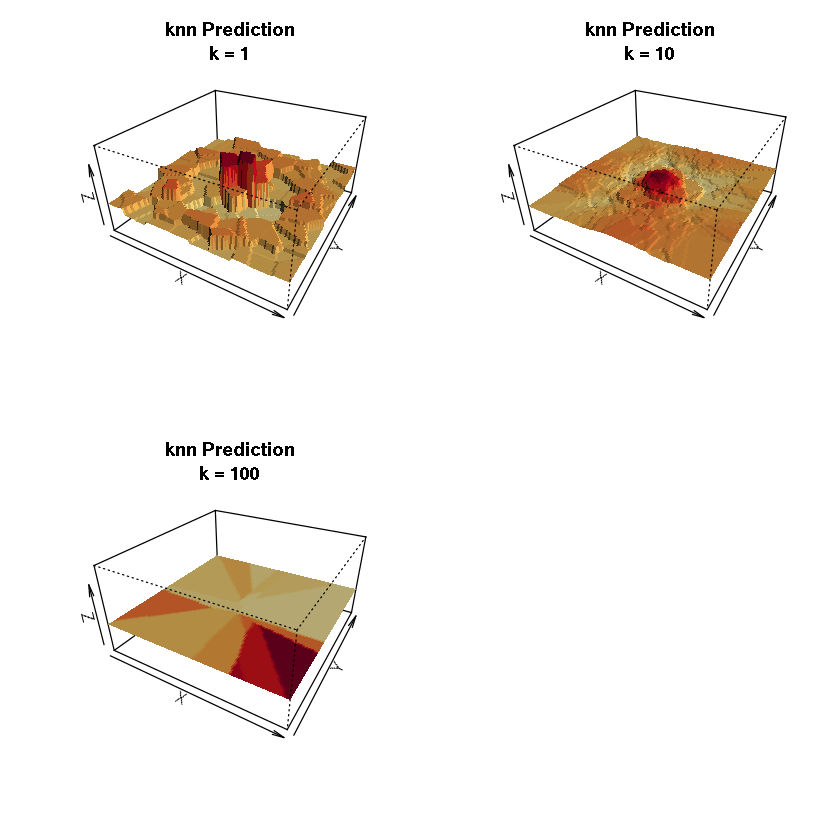

In [9]:
## Length of sub training dataset:
n_sub <- 102

## Define for which k-parameters you fit you knn-model:
k_vec <- c(1,10,100)
predictions <- list()
par(mfrow=c(2,2))
for(k in k_vec) {
    time_start <- Sys.time()
    
    ## 1) "Train" the model:
    fit.train <- train.kknn(z.noisy~x+y, train.data[sample(1:nrow(train.data), n_sub),], ks = k, kernel = "rectangular")
    
    ## 2) Get the predictions:
    predictions[[paste0("k",k)]] <- predict(fit.train,newdata=data)
    
    ## 4) Plot the predictions:
    plot.xyz.persp(x=data$x,y=data$y,z=predictions[[paste0("k",k)]], axnames=T,title=paste("knn Prediction\nk =",k))
    
    #print(paste("Time required for fit & prediction for k =",k))
    #print(Sys.time()-time_start)
}

<div class="alert alert-block alert-info">
<b>Questions</b> 

- Why does the prediction surface get "flatter" when $k$ is increased?
- What is the prediction for k=100?
</div>

Now repeat the same analysis for the full training dataset (N=5000):

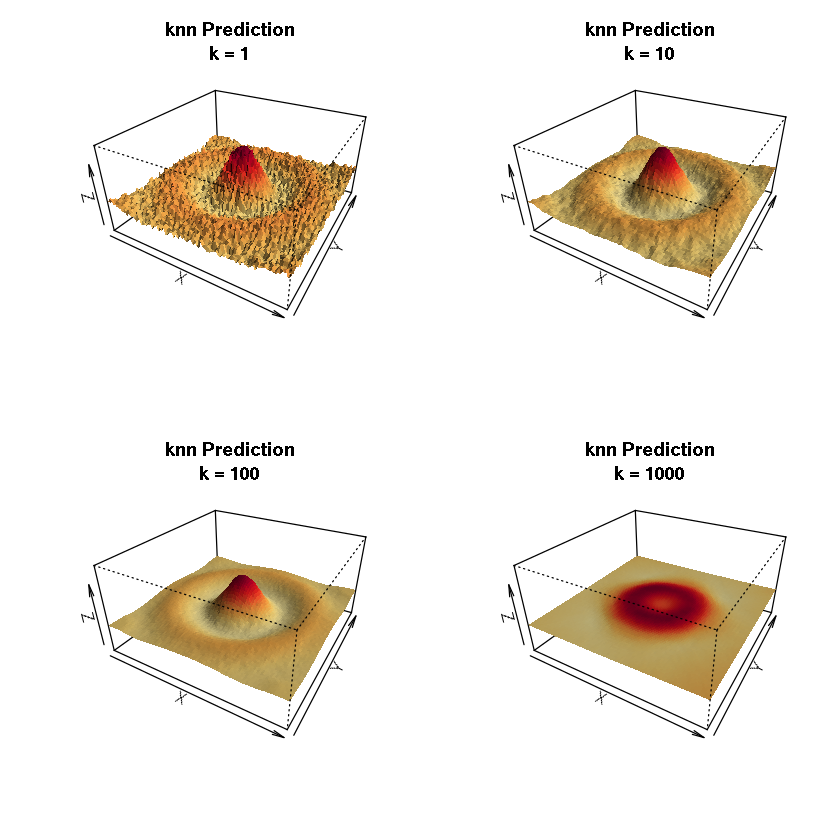

In [10]:
## Define for which k-parameters you fit you knn-model:
k_vec <- c(1,10,100,1000)
predictions <- list()
par(mfrow=c(2,2))
for(k in k_vec) {
    time_start <- Sys.time()
    
    ## 1) "Train" the model:
    fit.train <- train.kknn(z.noisy~x+y, train.data, ks = k, kernel = "rectangular")
    
    ## 2) Get the predictions:
    predictions[[paste0("k",k)]] <- predict(fit.train,newdata=data)
    
    ## 4) Plot the predictions:
    plot.xyz.persp(x=data$x,y=data$y,z=predictions[[paste0("k",k)]], axnames=T,title=paste("knn Prediction\nk =",k))
    
    #print(paste("Time required for fit & prediction for k =",k))
    #print(Sys.time()-time_start)
}

<div class="alert alert-block alert-info">
<b>Questions</b> 

- Why the strange interpolation with k=1000?
- How would you decide on which k parameter is optimal?
    
</div>

### Other kernels (introduced in week 6)

Other Kernel Smoothers use more complex functions than just the mean of $k$ neighbors. Here are the results with some kernels that we discussed during the lecture.

<img src="figures/kernels.png" width=500 />

We use a low number of training data points, such that the effect becomes visible:

In [13]:
## Length of sub training dataset:
n_sub <- 200

## Set k (leave NULL for the moment)
k_fix <- NULL

## 1) Train the model with internal search for optimal k (similar to cross-validation, with nfolds=N,
##    so-called "leave-one-out method"):
zz.knn.rect.opt <- train.kknn(z.noisy~x+y, train.data[sample(1:nrow(train.data), n_sub),],
                              kmax=50,ks=k_fix,kernel="rectangular")
zz.knn.epan.opt <- train.kknn(z.noisy~x+y, train.data[sample(1:nrow(train.data), n_sub),],
                              kmax=50,ks=k_fix,kernel="epanechnikov")
zz.knn.triw.opt <- train.kknn(z.noisy~x+y, train.data[sample(1:nrow(train.data), n_sub),],
                              kmax=50,ks=k_fix,kernel="triweight")
zz.knn.norm.opt <- train.kknn(z.noisy~x+y, train.data[sample(1:nrow(train.data), n_sub),],
                              kmax=50,ks=k_fix,kernel="gaussian")

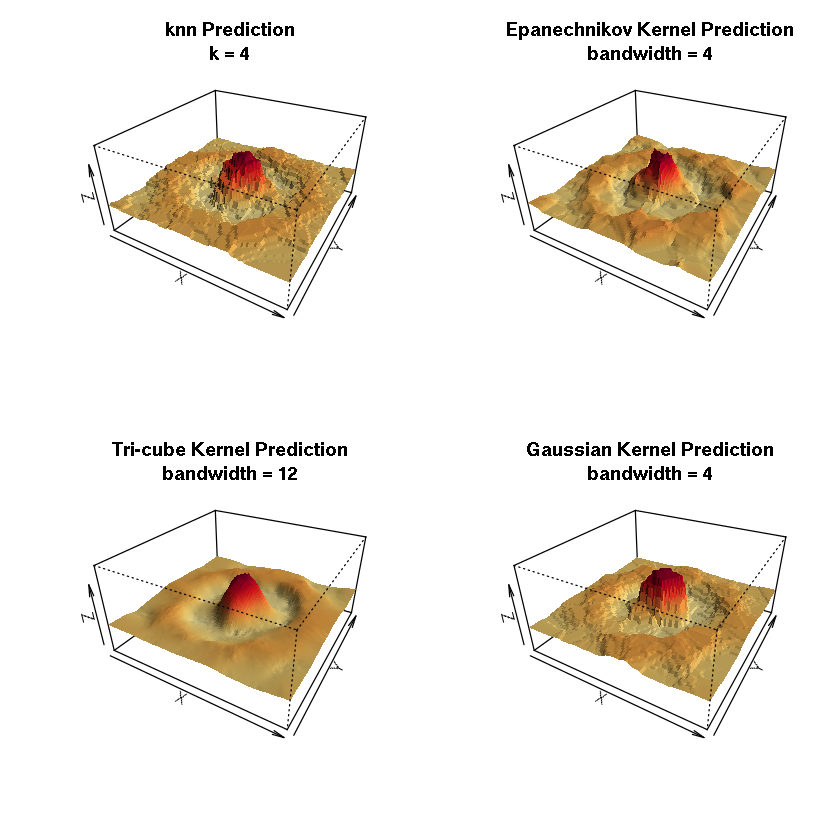

In [14]:
## 2) Plot the predictions:
par(mfrow=c(2,2))
plot.xyz.persp(x=data$x,y=data$y,z=predict(zz.knn.rect.opt,newdata=data),
               title=paste("knn Prediction\nk =",zz.knn.rect.opt$best.parameters$k))
plot.xyz.persp(x=data$x,y=data$y,z=predict(zz.knn.epan.opt,newdata=data),
               title=paste("Epanechnikov Kernel Prediction\nbandwidth =",zz.knn.epan.opt$best.parameters$k))
plot.xyz.persp(x=data$x,y=data$y,z=predict(zz.knn.triw.opt,newdata=data),
               title=paste("Tri-cube Kernel Prediction\nbandwidth =",zz.knn.triw.opt$best.parameters$k))
plot.xyz.persp(x=data$x,y=data$y,z=predict(zz.knn.norm.opt,newdata=data),
               title=paste("Gaussian Kernel Prediction\nbandwidth =",zz.knn.norm.opt$best.parameters$k))

<div class="alert alert-block alert-info">
<b>Questions</b> 

- How would the "kernel" for knn look like in the plot taken from the lecture slides?
- How do the different kernel predictions differ?
- Fix a certain k (instead of having ```k <- NULL```, set e.g. ```k <- 20```), what is the effect of the neighbourhood size / bandwidth?
- How do these methods differe for larger training sets (change ```n_sub <- 200``` to a larger value)?

</div>

## Local regression

Another easy Kernel Smoother is fitting a local regression function. 

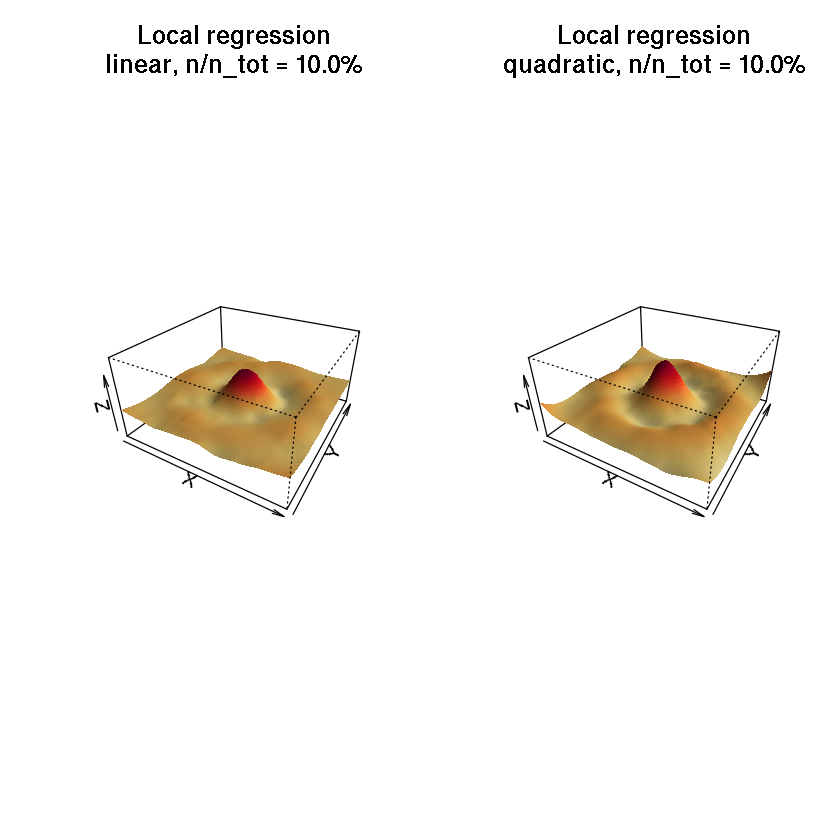

In [15]:
## Define fraction of points which should be considered for fitting:
n_frac <- 0.1

## Length of sub training dataset:
n_sub <- 200

## Fit local regression (linear and quadratic):
zz.locfit.1deg <- locfit(z.noisy~lp(x, y, nn=n_frac, deg=1),
                         data=train.data[sample(1:nrow(train.data), n_sub),])
zz.locfit.2deg <- locfit(z.noisy~lp(x, y, nn=n_frac, deg=2),
                         data=train.data[sample(1:nrow(train.data), n_sub),])

## Plot the local regression predictions:
par(mfrow=c(1,2))
plot.xyz.persp(x=data$x,y=data$y,z=predict(zz.locfit.1deg,newdata=data),
               title=sprintf("Local regression\nlinear, n/n_tot = %.1f%%",n_frac*100))
plot.xyz.persp(x=data$x,y=data$y,z=predict(zz.locfit.2deg,newdata=data),
               title=sprintf("Local regression\nquadratic, n/n_tot = %.1f%%",n_frac*100))

<div class="alert alert-block alert-info">
<b>Questions</b> 

- What happens when only a small fraction of training data points is used for the local regression fitting (e.g. setting ```n <- 0.05``` or lower)?

</div>

## Decision Trees

Another family of non-parametric methods are Decision Trees. Decision Trees are often also used outside the statistical learning context to visualise the process of decision making: 

<img src="figures/decision_tree.png" width=400 height=450 />


They can equivalently be used in Statistical Learning to divide the data into *leaves*. Going down a constructed decision tree will give a prediction for any new datapoints. Decision Trees have much more hyperparameters than many methods (remember that a Ridge Regression has only one, $\lambda$) that have to be set using Cross-Validation. Some of the important hyperparameters are:

- the number of data points `minsize` remaining in a node below which the node is a *leaf* (i.e. the tree is no further branched from there)
- the difference between two nodes after a split is made `mindev` as a fraction of the deviance of the root node. The smaller this hyperparameter is, the more splits are made, even if the explained differences between the two nodes is small (potentially overfitting the noise).
- the number of variables $m$ from the full set of predictors that is used to split at each node

In R, `tree` works with the *formula* interface. It has many settings, we will use some of them later. You can inspect the documentation of the function:

In [16]:
## Look at the documentation for the function for fitting a regression tree
?tree

make_tree {igraph},R Documentation
n,Number of vertices.
children,"Integer scalar, the number of children of a vertex (except for leafs)"
mode,"Defines the direction of the edges. out indicates that the edges point from the parent to the children, in indicates that they point from the children to their parents, while undirected creates an undirected graph."
...,Passed to make_tree.


In [17]:
## Look at the documentation for the function for making predictions
?predict.tree

predict.tree {tree},R Documentation
object,fitted model object of class tree. This is assumed to be the result of some function that produces an object with the same named components as that returned by the tree function.
newdata,"data frame containing the values at which predictions are required. The predictors referred to in the right side of formula(object) must be present by name in newdata. If missing, fitted values are returned."
type,character string denoting whether the predictions are returned as a vector (default) or as a tree object.
split,"governs the handling of missing values. If false, cases with missing values are dropped down the tree until a leaf is reached or a node for which the attribute is missing, and that node is used for prediction. If split = TRUE cases with missing attributes are split into fractional cases and dropped down each side of the split. The predicted values are averaged over the fractions to give the prediction."
nwts,"weights for the newdata cases, used when predicting a tree."
eps,"a lower bound for the probabilities, used if events of predicted probability zero occur in newdata when predicting a tree."
...,further arguments passed to or from other methods.


We start by growing a simple Decision Tree with the default settings on our artificial test dataset and inspect the resulting tree:


Regression tree:
tree(formula = z.noisy ~ x + y, data = train.data)
Number of terminal nodes:  11 
Residual mean deviance:  1.263 = 6301 / 4989 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-4.106000 -0.755800 -0.002364  0.000000  0.777100  5.128000 

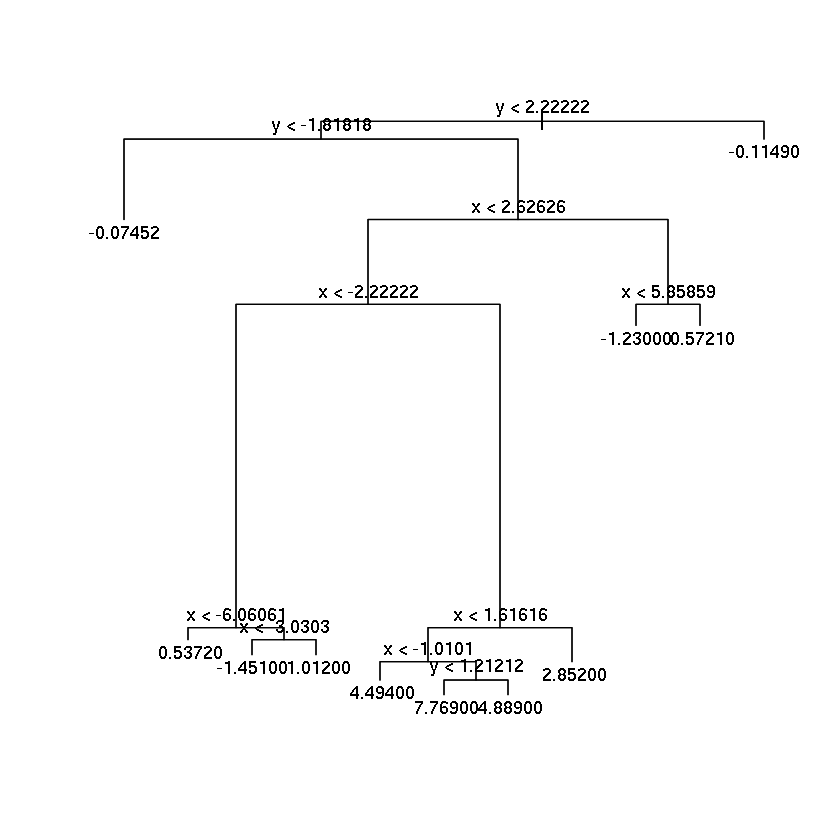

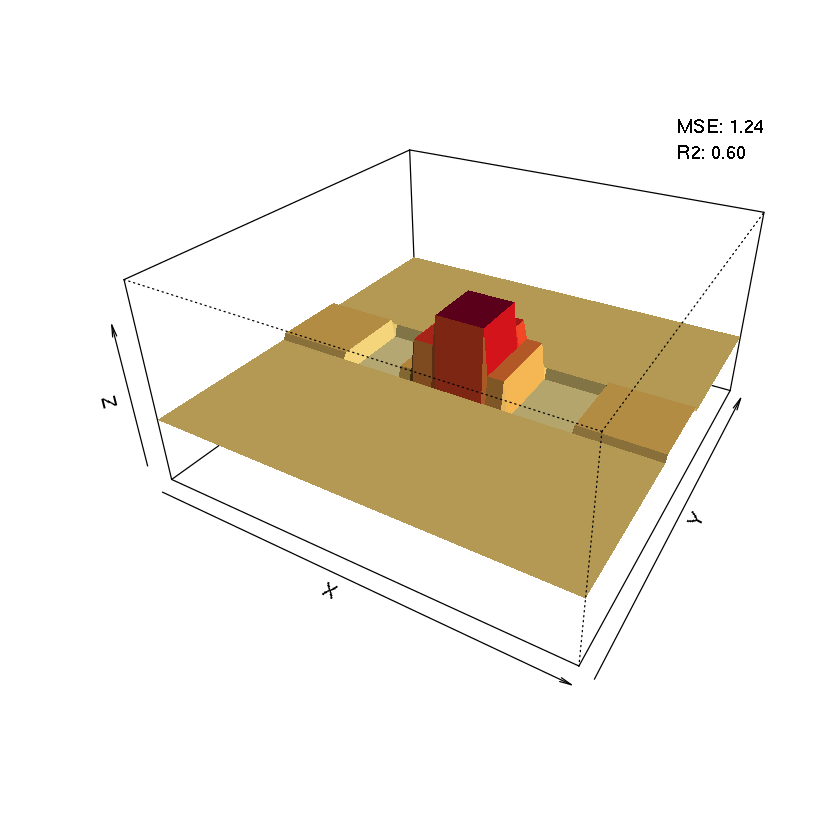

In [18]:
## Build simple tree:
tree.simple.fit <- tree(z.noisy~x+y,data=train.data)

## Summarise the tree
summary(tree.simple.fit)

## Plot the tree structure
plot(tree.simple.fit)
text(tree.simple.fit)

## Predict both test data (for error measures) and full dataset (for plotting):
tree.test.pred <- predict(tree.simple.fit,newdata=test.data)
tree.full.pred <- predict(tree.simple.fit,newdata=data)

## Plot full tree:
plot.xyz.persp(x=data$x,y=data$y,z=tree.full.pred)
legend("topright",legend=c(sprintf("MSE: %.2f",MSE(obs=test.data$z.noisy,pred=tree.test.pred)),
                           sprintf("R2: %.2f", R2(obs=test.data$z.noisy,pred=tree.test.pred))),
       bty = "n")

You can compare the tree structure with the prediction surface to get a feeling how the Decision Tree works. For example, you can imagine an arbitrary value for `x` and `y`, go down the tree and see in which leaf you end up. Then compare to the 3D plot to find the corresponding plateau in the prediction surface.

<div class="alert alert-block alert-info">
<b>Questions</b> 

- Can you identify the splits in the plot above (the X and Y axis go from -10 to 10)?

</div>

You can see in the plot above the MSE and R2 of the resulting tree. As you might have already guessed by visually inspecting the prediction surface, this tree is too simple to predict the complex dataset that we have created.  This is because in the default settings, `mindev` and `minsize` are set such that the tree growth is quite restricted. 

To allow the tree to grow larger, we set the minimum within-node deviance `mindev` and the number of data points in the terminal leaf `minsize` to smaller values. Compare the two plots, MSE and R2 to see that indeed the tree has a better performance now.


Regression tree:
tree(formula = z.noisy ~ x + y, data = train.data, mindev = 1e-05, 
    minsize = 1)
Number of terminal nodes:  2086 
Residual mean deviance:  0.07946 = 231.5 / 2914 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.1250 -0.1113  0.0000  0.0000  0.1143  1.1640 

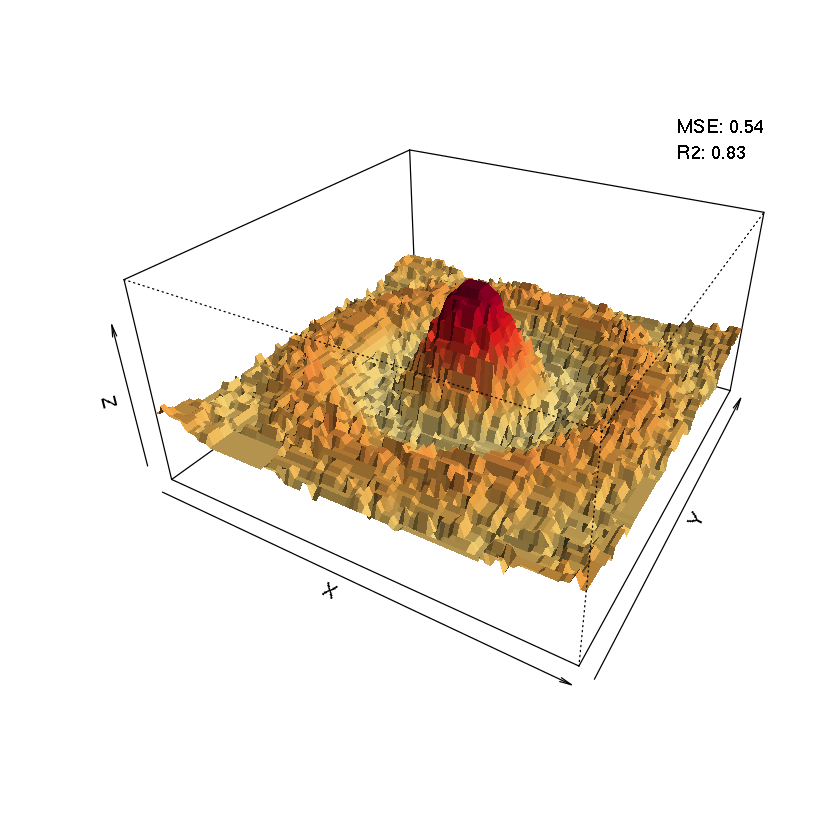

In [19]:
## Build tree:
tree.full.fit <-  tree(z.noisy~x+y,data=train.data,
                       mindev=0.00001,
                       minsize=1) 
summary(tree.full.fit)

## Predict both test data (for error measures) and full dataset (for plotting):
tree.full.test.pred <- predict(tree.full.fit,newdata=test.data)
tree.full.full.pred <- predict(tree.full.fit,newdata=data)

## Plot full tree
plot.xyz.persp(x=data$x,y=data$y,z=tree.full.full.pred)
legend("topright",legend=c(sprintf("MSE: %.2f",MSE(obs=test.data$z.noisy,pred=tree.full.test.pred)),
                           sprintf("R2: %.2f", R2(obs=test.data$z.noisy,pred=tree.full.test.pred))),
       bty = "n")

<div class="alert alert-block alert-info">
<b>Questions</b> 

- How many terminal nodes do the two trees have?
- Do you expect that the predictions closely match the "true values"? 
- What method would you use to find the optimal pruning parameter?

</div>

Of course, as it is already deeply ingrained in our statistical learning "minds", one does not simply set a hyper parameter. The course towards finding optimal parameters for any method is always *mighty* **Cross-Validation**.

Exemplarily, we explore now the optimal setting for the number of terminal nodes `minsize`.

(If we would cross-fit more than one of the many Tree parameters, Cross-Validation happens accross many dimensions and can quickly become expensive.)

<div class="alert alert-block alert-danger">
ATTENTION: This cell might take a minute or so...
</div>

In [20]:
## Set seed (initial value of random number generator to make results reproducable)
set.seed(102)
tree.opt.cv <- modified.cv.tree(tree.full.fit,K=10)

Tue Nov 17 21:29:45 2020 k = 1 of 10 
Tue Nov 17 21:29:49 2020 k = 2 of 10 
Tue Nov 17 21:29:52 2020 k = 3 of 10 
Tue Nov 17 21:29:55 2020 k = 4 of 10 
Tue Nov 17 21:29:59 2020 k = 5 of 10 
Tue Nov 17 21:30:02 2020 k = 6 of 10 
Tue Nov 17 21:30:06 2020 k = 7 of 10 
Tue Nov 17 21:30:10 2020 k = 8 of 10 
Tue Nov 17 21:30:13 2020 k = 9 of 10 
Tue Nov 17 21:30:17 2020 k = 10 of 10 


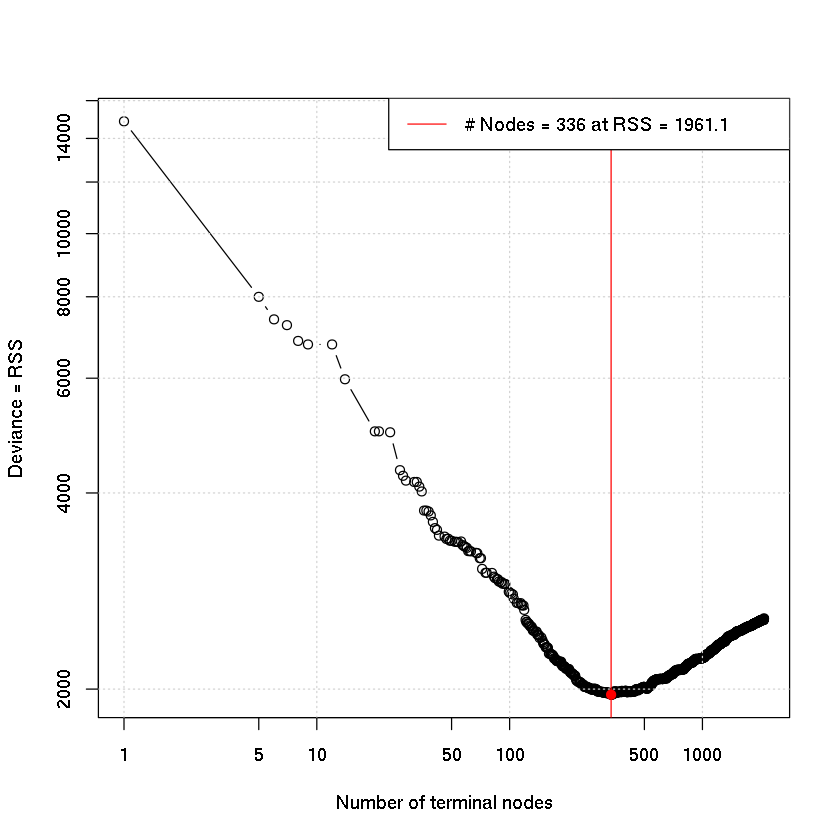

In [22]:
## Find minimal residual sum of Squares (like MSE, just not the mean but the sum)
## and the associated optimal tree size (number of terminal nodes):
size_min <- which.min(tree.opt.cv$dev)
plot(tree.opt.cv$size,tree.opt.cv$dev,
     type="b",log="xy",xlab="Number of terminal nodes",ylab="Deviance = RSS")
grid()
abline(v=tree.opt.cv$size[size_min], col="red")
points(tree.opt.cv$size[size_min] ,tree.opt.cv$dev[size_min],pch=19,col="red")
legend("topright",
       legend=sprintf("# Nodes = %i at RSS = %.1f",tree.opt.cv$size[size_min],
                      tree.opt.cv$dev[size_min]),
       lwd=1,col="red",bg="white")

The optimal tree has 336 terminal nodes. We plot the prediction surface and inspect MSE and R2 of this tree:

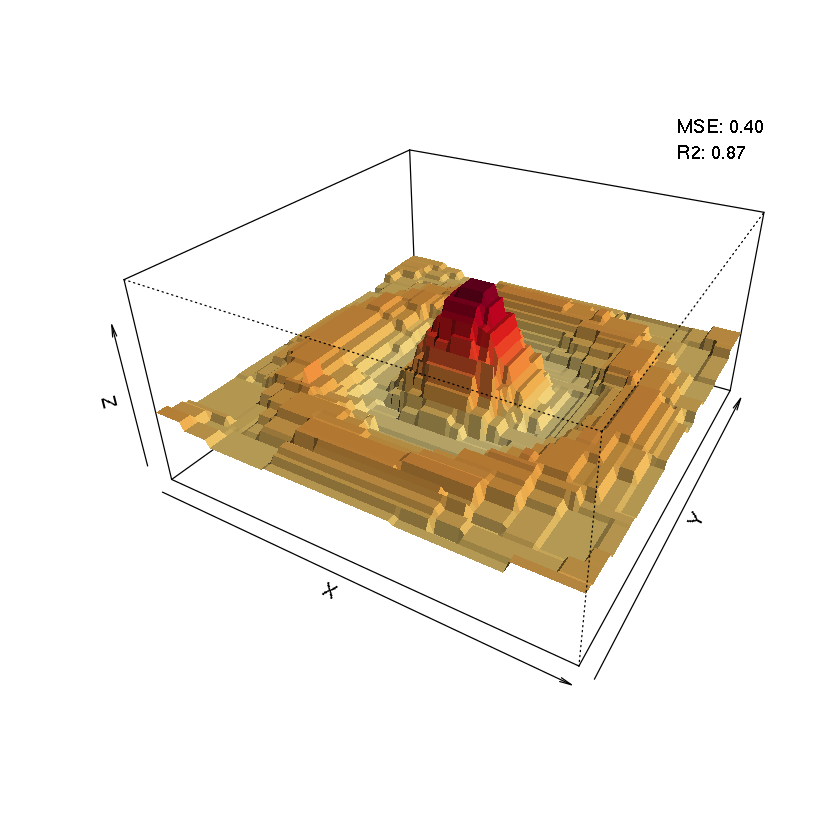

In [23]:
## Prune to optimal tree:
optimal.tree <- prune.tree(tree.full.fit,best=tree.opt.cv$size[size_min])

## Get prediction on test data and full dataset:
optimal.tree.test.prediction <- predict(optimal.tree,newdata=test.data)
optimal.tree.full.prediction <- predict(optimal.tree,newdata=data)

## Plot optimal prediction:
plot.xyz.persp(x=data$x,y=data$y,z=optimal.tree.full.prediction)
legend("topright",legend=c(sprintf("MSE: %.2f",MSE(obs=test.data$z.noisy,pred=optimal.tree.test.prediction)),
                           sprintf("R2: %.2f", R2(obs=test.data$z.noisy,pred=optimal.tree.test.prediction))),
       bty = "n")

## Bagging

In the last lecture, you have learned about Bagging (Bootstrap aggregating). Bagging means fitting the selected model repeatedly on a bootstrap sample of the data (a sample with replacement, in German "Ziehen mit Zurücklegen", i.e. a datapoint can be more than once in this dataset). This can improve accuracy considerably. 

Since it is easier to understand the concept of Bagging in a 1D-model, we re-use the artificial dataset created in the first exercise, witch is a 1D slice of our 2D droplet dataset (used in the first part of this exercise) with added noise:

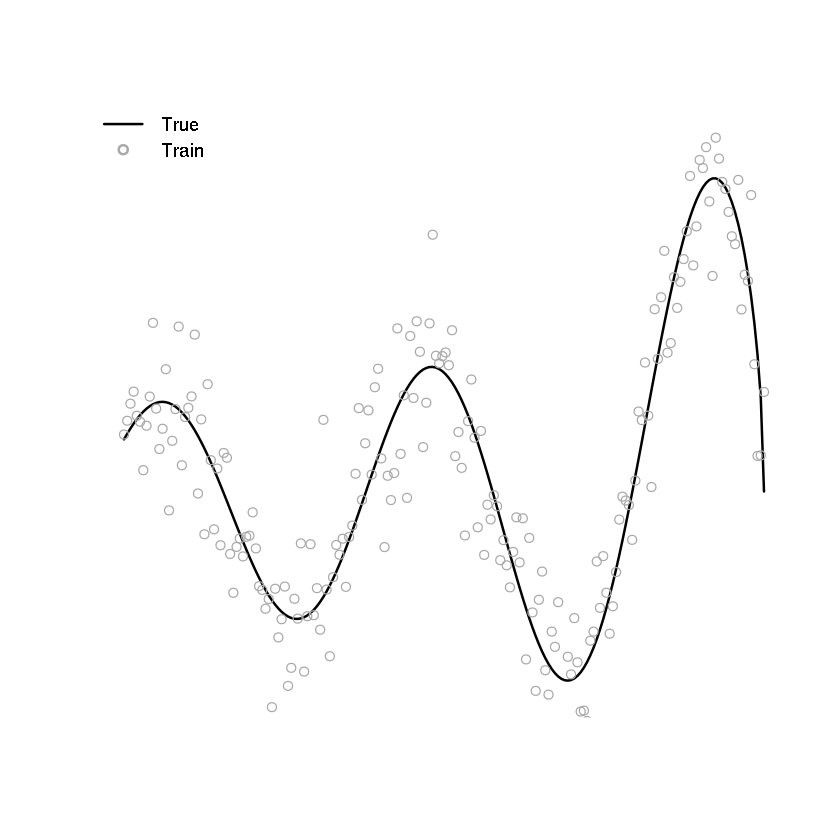

In [24]:
## Load function to create dataset from exercise 1:
source('../Exercise1/functions.R')

## Generate 200 training sample points:
train.data = generate.data.poly(N=200, seed=200, sd.noise=0.15)

## Plot true function and training dataset:
plot(train.data$X, train.data$Y_true, lwd=2, type="l", ylim=c(-0.5,1),axes=F, xaxt='n', ann=FALSE)
points(train.data$X, train.data$Y,col="darkgrey")
legend("topleft",legend=c("True","Train"),col=c("black","darkgrey"),
       lty=c(1,NA),pch=c(NA,1),lwd=2, bty = "n")

On this dataset, we now want to iteratively fit Decision Trees on "bagged" sampled of the data.

For that we first, we define a function, which takes the training data ```dat``` and the points for which it should make a prediction ```x.pred```, draws a random sample (with replacement ```replace=T```, of size N ```size=nrow(dat)```), fits a regression tree to this subsample and returns the predictions at ```x.pred```.

In [33]:
ind_sample <- sample(1:10, size=10, replace=T) # replace here is 重置
ind_sample

[1] 10  9  8  2  8  6  9  8  7  5

In [34]:
## Define function which does the bagging (selects sample of training data, 
## fits a tree, returns predictions):
tree_bagging_prediction <- function(dat,x.pred,return.ind_sample=F) {
    ind_sample <- sample(1:nrow(dat), size=nrow(dat), replace=T)
    tree.bag.fit <-  tree(Y~X,data=dat[ind_sample,],
                       mindev=0.005,
                       minsize=1) 
    tree.bag.test.pred <- predict(tree.bag.fit,newdata=data.frame(X=x.pred))
    if(return.ind_sample) {return(list(pred=tree.bag.test.pred, ind.samp=ind_sample))}
    else {return(tree.bag.test.pred)}
}

We execute this function four times, resulting in four "bagged" estimates for the fitted Decision Tree.

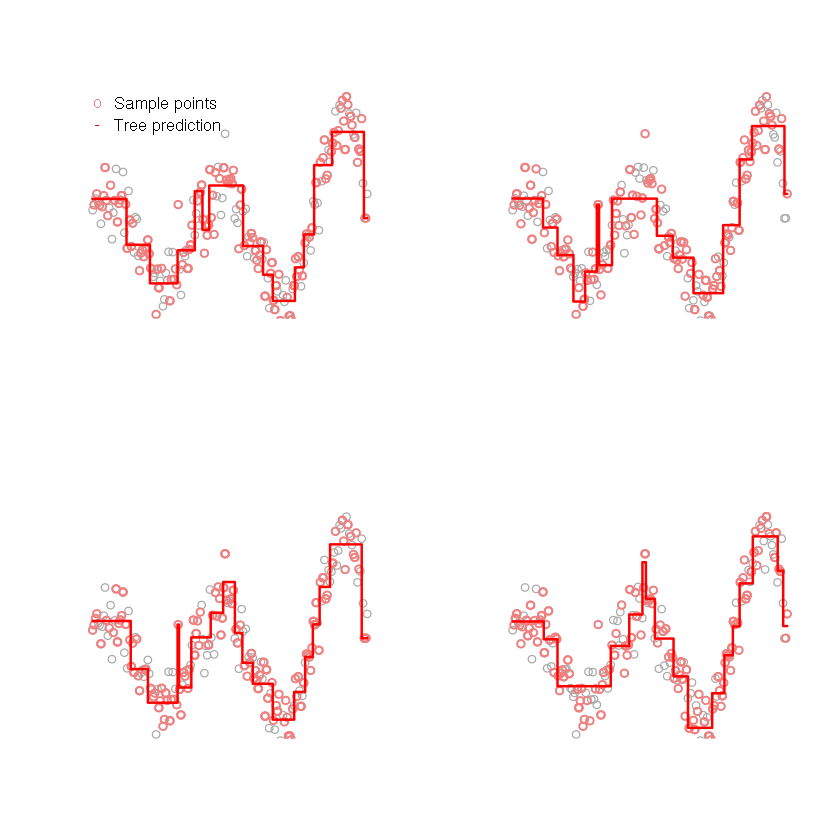

In [35]:
par(mfrow=c(2,2))
set.seed(1234)
for(i in 1:4) {
    res <- tree_bagging_prediction(train.data, x.pred=seq(0,15,0.01),return.ind_sample=T)
    plot(train.data$X, train.data$Y, ylim=c(-0.5,1),axes=F, xaxt='n', ann=FALSE,col="darkgrey")
    points(train.data$X[res$ind.samp], train.data$Y[res$ind.samp],col="lightcoral",lwd=1.5)
    lines(seq(0,15,0.01), res$pred, col="red", type="s", lwd=2)
    if(i==1) legend("topleft", legend=c("Sample points","Tree prediction"), col=c("lightcoral","red"),
                    pch=c("o","-"), bty="n")
}

You can see that between plots the data points that are used for training are different, and the resulting Decision Tree functions also differ.

We can considerably improve this prediction by repeating the bagging procedure 200 times and plot the median prediction and the 95% prediction interval:

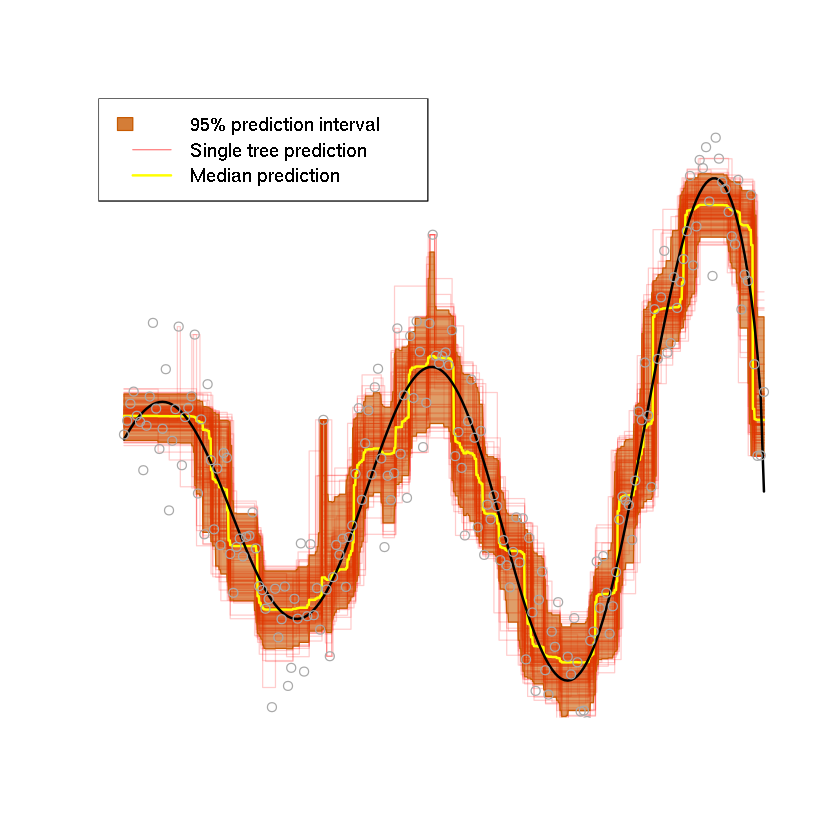

In [36]:
## Get bagging predictions for 100 replicates:
set.seed(321)
bag_res <- replicate(200, tree_bagging_prediction(dat=train.data,x.pred=seq(0,15,0.01)), simplify = T)

## Obtain 2.5% and 97.5% quantiles:
bag_res_quantiles <- apply(bag_res,1,quantile,c(0.025,0.5,0.975))

## Plot single bagging predictions and 95%-CI prediction interval: 
matplot(x=seq(0,15,0.01), y=bag_res, col=rgb(1,0,0,0.2),type="s",
        ylim=c(-0.5,1),axes=F, xaxt='n', ann=FALSE, lty=1)
polygon(x=c(seq(0,15,0.01),rev(seq(0,15,0.01))),
        y=c(bag_res_quantiles[1,],rev(bag_res_quantiles[3,])),
        col=rgb(200,90,1,alpha=150,maxColorValue=255),border=rgb(200,90,1,maxColorValue=255))       
lines(seq(0,15,0.01), bag_res_quantiles[2,], lwd=2, type="l", col="yellow")
lines(train.data$X, train.data$Y_true, lwd=2, type="l")
points(train.data$X, train.data$Y,col="darkgrey")
legend("topleft", legend=c("95% prediction interval","Single tree prediction","Median prediction"), lwd=c(NA,1,2),
       fill=c(rgb(200,90,1,alpha=200,maxColorValue=255),NA,NA),
       border=c(rgb(200,90,1,maxColorValue=255),NA,NA),
       col=c(NA,rgb(1,0,0,0.5),"yellow"))

The usually unknown "true function" (in black) is within the envelope of the percentiles. With the median, we have created a bagged Decision Tree estimate. 

## Random Forest

A Random Forest is *almost* the same as a bagged Decision Tree - remember how in the lecture we discussed the two randomizations of Random Forests: (1) Bagging of data points (as done above) and (2) selecting randomly a subset of variables for the prediction. Since above we only had a 1D dataset, it does not make sense to select a subset of variables.

Therefore, we switch to another dataset - the PSL/precipitation dataset that you might remember from the first lecture, where we predicted precipitation in Zürich using the sea level pressure (PSL) of surrounding grid points. This is how the data looks like:

| | y | X_1 | X_2 | ... | X_p |
| :- | :- | :- | :- | :- | :- |
| | Precip_Zurich | PSL_lon$_1$lat$_1$ | PSL_lon$_2$lat$_1$ | .... | PSL_lon$_x$lat$_y$ |
| December year$_1$ | 0.242 | 156 | 81.5 | ... | ... | 
| January year$_2$ | -1.115 | 63.5 | 78 | ... | ... | 
| February year$_2$ | 2.129 | 78 | 117 | ... | ... | 
| December year$_2$ | -1.574 | 128.81 | -207.7 | ... | ... | 
| January year$_3$ | -1.333 | 170.6 | 53.3 | ... | ... | 
| ... |... | ... | ... | ... | ... | 
| December year$_n$ | ... | ... | ... | ... | ... | 
| January year$_n$ | ... | ... | ... | ... | ... | 
| February year$_n$ | ... | ... | ... | ... | ... | 

<img src="figures/Precip_PSL.png" width=300 height=450 />

We load the data and divide into training and validation parts:

In [37]:
## Load data from Exercise 2 Part 1:
load("data/Exercise3_Part1_Data.RData")
str(Precip_PSL_df[,1:3])

## Rename predictor column names (otherwise the function call "Precip_Zurich ~ ." would not work):
Precip_PSL_df_new <- Precip_PSL_df
names(Precip_PSL_df_new)[2:ncol(Precip_PSL_df_new)] <- paste0("PSL",1:(ncol(Precip_PSL_df_new)-1))

## Specify training and validation indices:
set.seed(1234)
ind_train     <- sample(1:nrow(Precip_PSL_df), 2700)
ind_test      <- which(!(1:nrow(Precip_PSL_df) %in% ind_train))

'data.frame':	3000 obs. of  3 variables:
 $ Precip_Zurich   : num  0.242 -1.115 2.129 -1.574 -1.333 ...
 $ PSL_-10.00_31.26: num  156 63.5 160 -175.7 91.2 ...
 $ PSL_-7.50_31.26 : num  81.5 78 117 -207.7 53.3 ...


In [40]:
Precip_PSL_df_new %>% head()

,Precip_Zurich,PSL1,PSL2,PSL3,PSL4,PSL5,PSL6,PSL7,PSL8,PSL9,⋯,PSL348,PSL349,PSL350,PSL351,PSL352,PSL353,PSL354,PSL355,PSL356,PSL357
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.2415418,156.01743,81.50511,-3.490047,-33.51804,-67.11435,-85.306335,-86.49400,-99.29002,-101.6034,⋯,-205.1156,-206.4429,-200.8546,-178.4695,-128.0930,-68.29298,-13.26492,29.42711,68.86597,111.12390
2,-1.1148449,63.53567,77.95421,128.806366,170.64020,196.18723,216.788818,214.50902,233.07283,237.3653,⋯,338.2279,345.7426,338.6324,328.1504,288.5510,226.47061,167.56329,118.82137,84.57027,54.37339
3,2.1291978,159.96971,116.97428,120.619896,92.18759,34.59519,-9.755984,-64.84520,-116.36170,-207.1973,⋯,-573.8073,-623.3585,-670.3974,-701.5832,-723.7166,-744.95630,-739.83960,-731.32092,-728.52563,-719.78998
4,-1.5735213,-175.73257,-207.66676,-306.825989,-377.22116,-414.75497,-420.650085,-407.39243,-393.02438,-372.2909,⋯,1201.6656,1219.3696,1209.1532,1169.3899,1079.6804,973.73828,899.90698,839.09900,794.49878,759.79578
5,-1.3329688,91.19974,53.33702,26.861055,47.13238,77.89034,89.148193,88.65746,140.41658,205.2325,⋯,-117.3268,-105.4371,-109.1723,-114.3418,-127.8162,-126.06844,-135.05389,-127.70988,-122.21098,-135.81410
6,0.9231196,-125.73341,-204.83041,-367.341034,-461.39835,-521.30322,-553.373169,-567.64209,-551.68982,-515.7130,⋯,725.1068,796.1259,871.6807,963.4324,1081.8068,1225.78589,1356.86353,1441.59314,1505.54468,1570.49121


Now we fit a random forest model. The parameter ```mtry``` specifies the number of variables randomly sampled at each split, which we called `m`in the lecture. The default value here is 33%.

<div class="alert alert-block alert-danger">
ATTENTION: This cell might take a minute or so...
</div>

In [41]:
## Set fraction of variables which should be chosen randomly each split:
rnd_var_frac <- 0.3

## Set number of trees:
ntrees <- 100

set.seed(42)
rf.fit.var.imp <- randomForest(Precip_Zurich ~ .,
                               data=Precip_PSL_df_new[ind_train,],
                               ntree=ntrees,
                               mtry=floor(ncol(Precip_PSL_df_new[ind_train,])*rnd_var_frac),
                               importance=TRUE)

We can plot the Variable Importance of all the variables (sea level pressure at different locations) on a map to see which grid cell was most important for fitting the model:

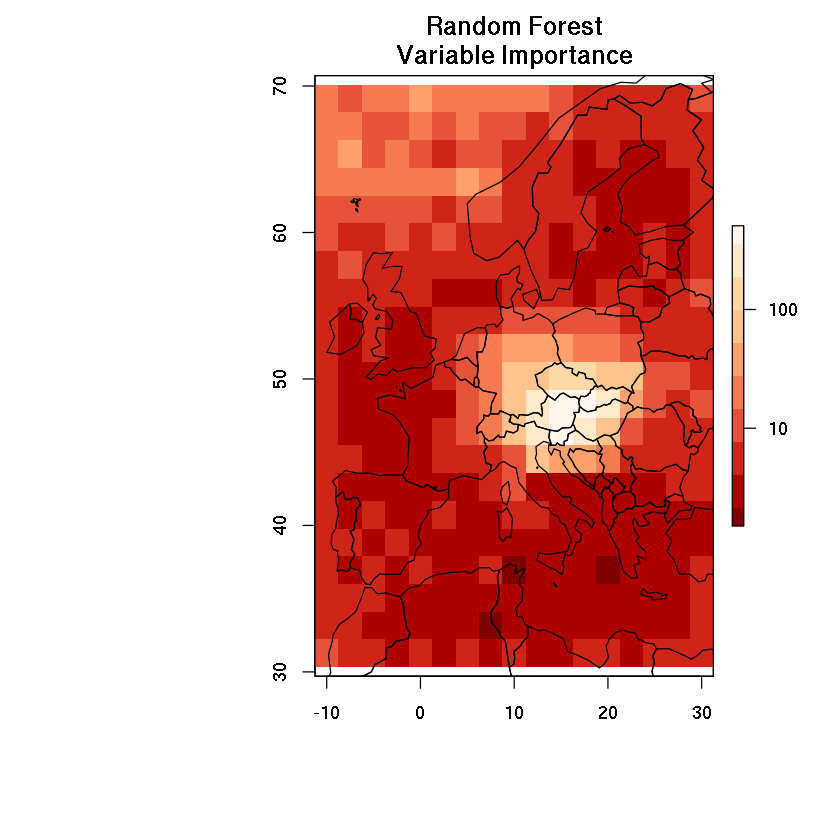

In [42]:
## Get feature importance:
imp <- importance(rf.fit.var.imp,type=2)

## Define colour scale:
col.div    <- colorRampPalette(rev(brewer.pal(n = 9, name = "OrRd")))(10)
ticks<- c(1,10,100,1000)

## Get coordinate grid and make spatial raster object:
spatial_raster <- raster(SpatialPixels(SpatialPoints(coords = coord_grid,
                         proj4string = CRS(projargs = "+proj=longlat"))))

## Plot mean PSL values of first month:
par(mfrow=c(1,1), mar=c(6.5,12.5,3,1))
plot.raster <- assign_values(log10(imp), spatial_raster)
plot(plot.raster, col = col.div, main="Random Forest\nVariable Importance",
     axis.args=list( at=log10(ticks), labels=ticks))
plot(countriesCoarse, add = T)

Unsurprisingly, the sea level pressure in grid cells close to Zürich have most predictive power for the estimation of precipitation at the Zürich grid point.

<div class="alert alert-block alert-info">
<b>Questions</b> 

- In which settings are non-parameteric functions better, in which settings is a parametric model sufficient?
- In which settings does a tree work well?

</div>

## [Bonus] compare Random Forest, knn and Decision Tree for real world data

For comparison with the Random Forest, we also fit a knn model (k=1) and optimised tree model to the PSL/precip data:

<div class="alert alert-block alert-danger">
ATTENTION: This cell might take a minute or so...
</div>

In [43]:
## Fit knn model and make prediction on test dataset:
knn.fit.train.PSL <- train.kknn(Precip_Zurich~., data=Precip_PSL_df[ind_train,], ks = 1, kernel = "rectangular")
knn.Precip.test.prediction <- predict(knn.fit.train.PSL,newdata=Precip_PSL_df[ind_test,])


## Fit full tree model, optimise size using CV, prune full tree and make prediction on test dataset:
tree.Precip.full.fit <-  tree(Precip_Zurich ~ .,
                              data=Precip_PSL_df_new[ind_train,],
                              mindev=0.002,
                              minsize=1) 

tree.Precip.opt.cv <- modified.cv.tree(tree.Precip.full.fit,K=10)
size_min <- which.min(tree.Precip.opt.cv$dev)

optimal.Precip.tree <- prune.tree(tree.Precip.full.fit,best=tree.Precip.opt.cv$size[size_min])

tree.Precip.test.prediction <- predict(optimal.Precip.tree, newdata=Precip_PSL_df_new[ind_test,])


## Make prediction with random forest model (fitted above) on test dataset:
rf.Precip.test.prediction <- predict(rf.fit.var.imp, newdata=Precip_PSL_df_new[ind_test,])

Tue Nov 17 21:48:37 2020 k = 1 of 10 
Tue Nov 17 21:48:37 2020 k = 2 of 10 
Tue Nov 17 21:48:38 2020 k = 3 of 10 
Tue Nov 17 21:48:38 2020 k = 4 of 10 
Tue Nov 17 21:48:39 2020 k = 5 of 10 
Tue Nov 17 21:48:40 2020 k = 6 of 10 
Tue Nov 17 21:48:40 2020 k = 7 of 10 
Tue Nov 17 21:48:41 2020 k = 8 of 10 
Tue Nov 17 21:48:42 2020 k = 9 of 10 
Tue Nov 17 21:48:42 2020 k = 10 of 10 


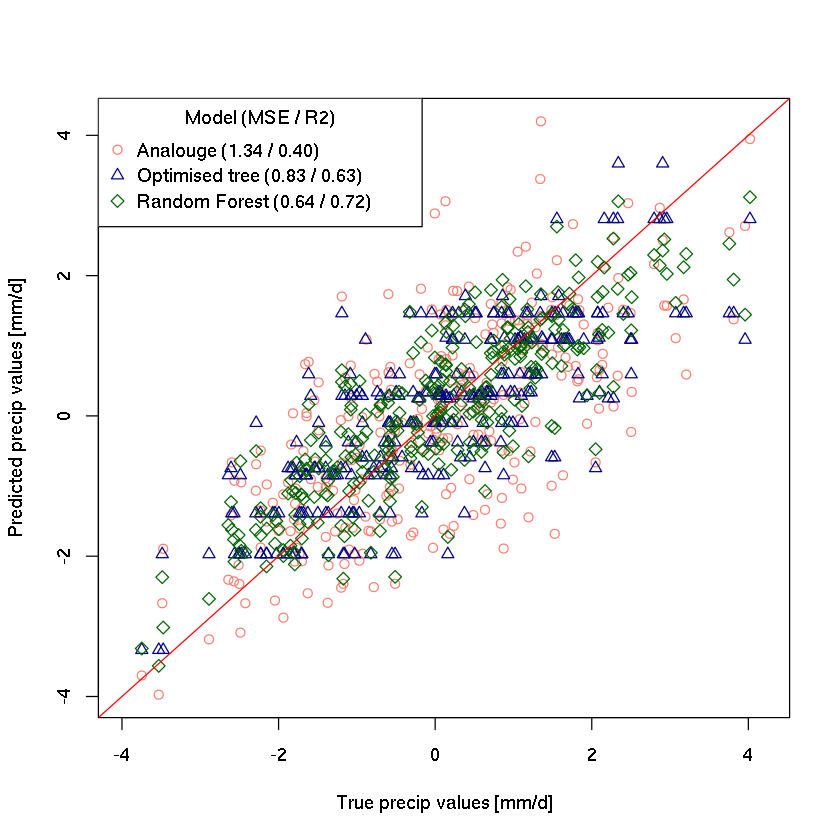

In [44]:
## Compare prediction with validation (test) data:
plot_range <- range(Precip_PSL_df$Precip_Zurich[ind_test],knn.Precip.test.prediction)
plot(Precip_PSL_df$Precip_Zurich[ind_test],knn.Precip.test.prediction,col="salmon",
     xlab="True precip values [mm/d]",ylab="Predicted precip values [mm/d]",
     xlim=plot_range,ylim=plot_range, pch=1)
points(Precip_PSL_df$Precip_Zurich[ind_test],tree.Precip.test.prediction,col="navyblue", pch=2)
points(Precip_PSL_df$Precip_Zurich[ind_test],rf.Precip.test.prediction,col="darkgreen", pch=5)
legend("topleft",
       legend=c(sprintf("Analouge (%.2f / %.2f)",
                        MSE(Precip_PSL_df$Precip_Zurich[ind_test],knn.Precip.test.prediction),
                        R2(Precip_PSL_df$Precip_Zurich[ind_test],knn.Precip.test.prediction)),
                sprintf("Optimised tree (%.2f / %.2f)",
                        MSE(Precip_PSL_df$Precip_Zurich[ind_test],tree.Precip.test.prediction),
                        R2(Precip_PSL_df$Precip_Zurich[ind_test],tree.Precip.test.prediction)),
                sprintf("Random Forest (%.2f / %.2f)",
                        MSE(Precip_PSL_df$Precip_Zurich[ind_test],rf.Precip.test.prediction),
                        R2(Precip_PSL_df$Precip_Zurich[ind_test],rf.Precip.test.prediction))),
      pch=c(1,2,5),col=c("salmon","navyblue","darkgreen"), title="Model (MSE / R2)")
abline(0,1,col="red")

<div class="alert alert-block alert-info">
<b>Questions</b> 

- How would you judge the predictive power of the knn (k=1) approach? 
- What is the model actually doing here?
- Would you think this method could be used for skillfull forecasting?
- Interpret the "layered" predictions of the optimised tree (blue triangles).
- Did the tree-based models perform better or worse then the analogue (knn, k=1) method?
- Which feature(s) of random forest make it advantegous in this setting?
- How can one explain that those (much more expensive) tree method do not significantly outperform the analogue method?
    
</dif>